# Rank Ordered Bayesian Optimization with Trust Regions (ROBOT)
In this tutorial, we show how to implement Rank Ordered Bayesian Optimization with Trust Regions (ROBOT) [1] in a closed loop in BoTorch to optimize a set of $M$ diverse solutions ($M$ solutions that are pairwise diverse from one another) that all optimize the black-box objective function. 

In this tutorial, we demonstrate using ROBOT to find $M=3$ diverse solutions to a the rover trajectory optimization task, as in section 4.1.1 of the original paper [1].  

[1]: [Maus, Natalie, et al. Discovering Many Diverse Solutions with Bayesian Optimization. AISTATS 2023.](https://proceedings.mlr.press/v206/maus23a/maus23a.pdf)

In [ ]:
import math
import os 
import numpy as np 
import torch 
import gpytorch 
import itertools
import scipy.interpolate as si
from dataclasses import dataclass
from botorch.generation import MaxPosteriorSampling 
from torch.quasirandom import SobolEngine
from torch.utils.data import TensorDataset, DataLoader
from gpytorch.mlls import PredictiveLogLikelihood 
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
from botorch.posteriors.gpytorch import GPyTorchPosterior
from gpytorch.kernels.kernel import Distance

import matplotlib.pyplot as plt
import matplotlib.patches as patches

dist_module = Distance()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float64
torch.set_default_dtype(torch.float64)
torch.manual_seed(42);
SMOKE_TEST = os.environ.get("SMOKE_TEST")

## Define model class for GP surrogate model
The GPModel class defined below is a standard approximate GP model defined using gpytorch. As in [1], we use an approximate GP model for increased speed when updating on large quantities of data. 
Additionally we define below a function update_gp that can be called to update the GP surrogate model on new data collected during optimization using gradient descent with the standard Adam optimizer. 

In [ ]:
class GPModel(ApproximateGP):
    def __init__(self, inducing_points, likelihood):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0) )
        variational_strategy = VariationalStrategy(
            self, 
            inducing_points, 
            variational_distribution, 
            learn_inducing_locations=True,
        )
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.num_outputs = 1
        self.likelihood = likelihood 

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    def posterior(
            self, X, output_indices=None, observation_noise=False, *args, **kwargs
        ) -> GPyTorchPosterior:
            self.eval()  
            self.likelihood.eval()
            dist = self.likelihood(self(X)) 
            return GPyTorchPosterior(dist)

def update_gp(
    model,
    mll,
    train_x,
    train_y,
    n_epochs=2,
    bsz=1024,
    lr=0.01,
):
    model.train() 
    optimizer = torch.optim.Adam([{'params': model.parameters(), 'lr': lr} ], lr=lr)
    train_bsz = min(len(train_y),bsz)
    train_dataset = TensorDataset(train_x.to(device=device), train_y.squeeze().to(device=device))
    train_loader = DataLoader(train_dataset, batch_size=train_bsz, shuffle=True)
    for _ in range(n_epochs):
        for (inputs, scores) in train_loader:
            optimizer.zero_grad()
            output = model(inputs.to(device=device))
            loss = -mll(output, scores.to(device=device))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
    model.eval()


## Trust region dynamics 
ROBOT [1] utilizes $M$ collaborative trust regions to discover a set of $M$ diverse solutions. Below, we define the standard trust region state data class, and a method for updating the state of the trust region, as defined in the original Trust Region Bayesian Optimization (TuRBO) paper [2]. 

[2]: [Eriksson, David, et al. Scalable global optimization via local Bayesian optimization. NeurIPS 2019.](https://proceedings.neurips.cc/paper/2019/file/6c990b7aca7bc7058f5e98ea909e924b-Paper.pdf)

In [ ]:
@dataclass
class TrustRegionState:
    center_point: torch.Tensor | None =  None 
    best_value: float = -float("inf") 
    length: float = 0.8 
    length_min: float = 0.5 ** 7
    length_max: float = 1.6
    failure_counter: int = 0
    failure_tolerance: int = 32 
    success_counter: int = 0
    success_tolerance: int = 10 
    restart_triggered: bool = False


def update_state(state: TrustRegionState, Y_next):
    if max(Y_next) > state.best_value + 1e-3 * math.fabs(state.best_value):
        state.success_counter += 1
        state.failure_counter = 0
    else:
        state.success_counter = 0
        state.failure_counter += len(Y_next) 

    if state.success_counter == state.success_tolerance:  # Expand trust region
        state.length = min(2.0 * state.length, state.length_max)
        state.success_counter = 0
    elif state.failure_counter == state.failure_tolerance:  # Shrink trust region
        state.length /= 2.0
        state.failure_counter = 0

    state.best_value = max(state.best_value, max(Y_next).item())
    if state.length < state.length_min:
        state.restart_triggered = True

## Acquisition (generating candidate points)
On each iteration of optimization, ROBOT [1] uses Thompson sampling to generate candidates from within each of the $M$ trust regions. Thompson sampling is straightforward to implement using BoTorch.

In [4]:
def generate_batch(
    tr_state, # trust region where we want to generate new candidates
    model, # GP surrogate model
    dim, # search space dim
    batch_size, # number of candidates to generate (acquisition batch size)
    lb, # lower bound of search space
    ub, # upper bound of search space
):
    # Generate batch of candidate points by Thompson sampling in the trust region tr_state
    n_candidates = min(5000, max(2000, 200 * dim))
    x_center = tr_state.center_point
    weights = torch.ones_like(x_center)
    weights = weights * (ub - lb)
    tr_lb = torch.clamp(x_center - weights * tr_state.length / 2.0, lb, ub) 
    tr_ub = torch.clamp(x_center + weights * tr_state.length / 2.0, lb, ub) 
    tr_lb = tr_lb.to(dtype=dtype,device=device)
    tr_ub = tr_ub.to(dtype=dtype,device=device)
    sobol = SobolEngine(dim, scramble=True) 
    pert = sobol.draw(n_candidates).to(dtype=dtype,device=device)
    pert = tr_lb + (tr_ub - tr_lb) * pert
    tr_lb = tr_lb.to(dtype=dtype,device=device)
    tr_ub = tr_ub.to(dtype=dtype,device=device)
    # Create a perturbation mask 
    prob_perturb = min(20.0 / dim, 1.0)
    mask = (torch.rand(n_candidates, dim, dtype=dtype, device=device)<= prob_perturb)
    ind = torch.where(mask.sum(dim=1) == 0)[0]
    mask[ind, torch.randint(0, dim - 1, size=(len(ind),), device=device)] = 1
    mask = mask.to(device=device)
    # Create candidate points from the perturbations and the mask
    X_cand = x_center.expand(n_candidates, dim).clone()
    X_cand = X_cand.to(dtype=dtype,device=device)
    pert = pert.to(dtype=dtype,device=device)
    X_cand[mask] = pert[mask]
    # Sample on the candidate points 
    thompson_sampling = MaxPosteriorSampling(model=model, replacement=False ) 
    X_next = thompson_sampling(X_cand.to(dtype=dtype,device=device), num_samples=batch_size )

    return X_next

## Set up the rover black-box optimization task 
In ths notebook, we optimize the same rover trajectory optimization task considered in [1]. The task consists of finding a 60 dimensional policy that allows a rover to move along some trajectory from a designated start point, to the "goal" point, while avoiding a set of obstacles. This optimization problem is useful for demonstrating the usefulness of ROBOT as it allows us to directly visualize the diverse solutions (trajectories) found by ROBOT. 

In [ ]:
class RoverObjective:
    def __init__(self,):
        self.dim = 60 
        self.lb =  -0.5 * 4 / self.dim 
        self.ub = 4 / self.dim 
        self.f_max = 5.0 
        self.const_cost_val = 0.05
        self.const_obs_cost_val = 20.0
        a = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
        c = np.array(list(itertools.product(a, a)))  
        c = c[1:-1] 
        self.obstacle_delta = 0.1
        self.obstacle_l = c - self.obstacle_delta / 2
        self.obstacle_h = c + self.obstacle_delta / 2
        r_box = np.array([[0.5, 0.5]])
        self.r_l = r_box - 0.5
        self.r_h = r_box + 0.5
        self.start = np.zeros(2) + 0.05
        self.goal = np.array([0.95, 0.95])


    # return the negative cost which we seek to optimize 
    def __call__(self, params):
        points = self.get_trajectory_points(params)
        # compute cost 
        trees_contain = self.contains(X=points, lows=self.obstacle_l, highs=self.obstacle_h)
        r_box_contain = self.contains(X=points, lows=self.r_l, highs=self.r_h)
        obstacle_cost = self.const_obs_cost_val * np.any(np.hstack([trees_contain, ~r_box_contain]), axis=1, keepdims=True)
        constant_cost = self.get_constant_cost(points)
        costs = np.sum(np.hstack([obstacle_cost, constant_cost]), axis=1)
        # estimate (trapezoidal) the integral of the cost along traj 
        avg_cost = 0.5 * (costs[:-1] + costs[1:])
        l = np.linalg.norm(points[1:] - points[:-1], axis=1)
        total_cost = np.sum(l * avg_cost)
        total_cost += 100 * np.linalg.norm(points[-1] - self.goal, 1)
        reward = total_cost*-1 + self.f_max 
        return reward.item() 

    def get_constant_cost(self, X):
        if X.ndim == 1:
            X = X[None, :]
        return np.ones((X.shape[0], 1)) * self.const_cost_val

    def contains(self, X, lows, highs):
        if X.ndim == 1:
            X = X[None, :]
        lX = lows.T[None, :, :] <= X[:, :, None]
        hX = highs.T[None, :, :] > X[:, :, None]
        return lX.all(axis=1) & hX.all(axis=1)

    def get_trajectory_points(self, params):
        points = np.hstack((self.start[:, None], params.reshape((-1, 2)).T)).cumsum(axis=1)
        xp = points[0]
        yp = points[1]
        okay = np.where(np.abs(np.diff(xp)) + np.abs(np.diff(yp)) > 0)
        xp = np.r_[xp[okay], xp[-1]]
        yp = np.r_[yp[okay], yp[-1]] 
        tck, _ = si.splprep([xp, yp], k=3, s=0)
        spacing = np.linspace(0, 1.0, 1000, endpoint=True)
        points = np.vstack(si.splev(spacing, tck)).T
        return points 

# create rover objective function 
rover_objective = RoverObjective()

# define a function to make it easier to call the black-box objective function a batch of candidate points
def f_batch(x_batch):
    rewards = []
    for x in x_batch:
        rewards.append(rover_objective(x))
    return torch.tensor(rewards).to(dtype=dtype, device=device).unsqueeze(-1)

## Visualizing the rover optimization task 
Below, we provide a visualization of the rover task. The start point for the rover is shown in green. The "goal" point that the rover tries to reach is shown in red. The obstacles that the rover must avoid on its way from the start point to the goal point are shown as dark red rectangles. 

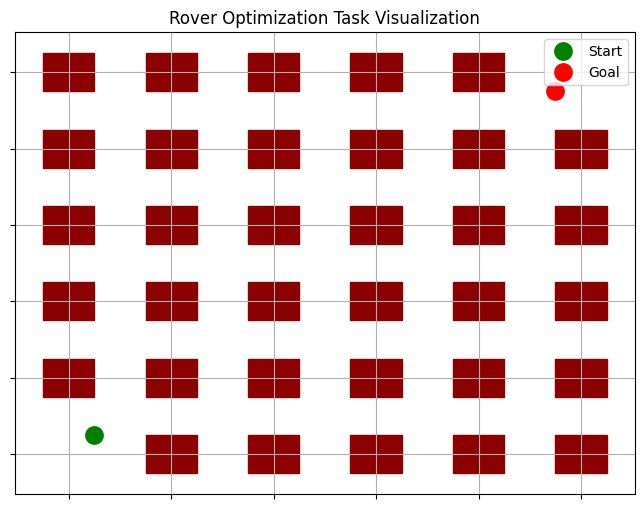

In [6]:
_, ax = plt.subplots(1, 1, figsize=(8, 6))
# Depict obstacles as dark red rectangles 
for i in range(len(rover_objective.obstacle_l)):
    rect = patches.Rectangle(
        (rover_objective.obstacle_l[i, 0], rover_objective.obstacle_l[i, 1]),
        rover_objective.obstacle_delta,
        rover_objective.obstacle_delta,
        linewidth=1,
        edgecolor="darkred",
        facecolor="darkred",
    )
    ax.add_patch(rect) 
plt.plot(0.05, 0.05, ".g", ms=25, label="Start") # Start
plt.plot(0.95, 0.95, ".r", ms=25, label="Goal") # Goal
plt.legend()
plt.grid(True)
plt.title("Rover Optimization Task Visualization")
# Add grid lines
ax.grid(True)
# Turn off axis labels (numbers) but keep ticks (and thus the grid lines)
ax.set_xticklabels([])  # Remove x-axis tick labels
ax.set_yticklabels([])  # Remove y-axis tick labels
plt.show();

## Diversity function and threshold
In addition to a black-box function to optimize, ROBOT [1] requires a user-defined diversity function $\delta$ and a diversity threshold $\tau$. ROBOT applies constraints such that any pair of solutions in its optimized set of $M$ solutions must have a diversity score (according to $\delta$) of at least $\tau$. 

For the rover optimization task, as in the original paper [1], we define the diversity function as the "one way distance" between a pair of paths taken by the rover, and we use $\tau=0.15$. Thus, the $M$ solutions found by ROBOT must be meaningfully diverse from one another, as the solutions are forced to take distinct routes around the obstacles. 

In [7]:
def delta(x1, x2 ):
    ''' Returns one way distance (OWD) (https://zheng-kai.com/paper/vldbj_2019.pdf)
        between two the trajectories/paths taken by the rover 
            d_proj(A,B) = (1/N_points) * Sum of Euclidian dist from each point in the A, to NEAREST point in the B 
            OWD(A, B) = mean(d_proj(A, B), d_proj(B, A)) --> symmetric distance metric 
    '''
    trajA = rover_objective.get_trajectory_points(x1)
    trajB = rover_objective.get_trajectory_points(x2)
    trajA = torch.from_numpy(trajA)
    trajB = torch.from_numpy(trajB)
    N = trajA.shape[-2]
    trajA, trajB = trajA.to(dtype=dtype,device=device), trajB.to(dtype=dtype,device=device)
    dist_matrix = dist_module._dist(trajA, trajB, postprocess=False)
    dists_AB, _ = torch.min(dist_matrix, dim=-1)
    dists_BA, _ = torch.min(dist_matrix, dim=-2) 
    return 0.5*( (dists_AB.sum(dim=-1)/N)+(dists_BA.sum(dim=-1)/N) )

TAU = 0.15

def is_feasible(cand_x, higher_ranked_xs): 
    '''
    Helper function used to check if a candidate point cand_x 
        is sufficiently diverse from all points in the list higher_ranked_xs
    '''
    for x in higher_ranked_xs:
        if delta(cand_x, x) < TAU:
            return False 
    return True 

## ROBOT trust region recentering 
On each iteration of ROBOT, the $M$ trust regions are re-centered on the best feasible set of $M$ solutions found so far. Here, "feasible" means that the $M$ solutions meet the diversity constraints according to the diversity function $\delta$ and a diversity threshold $\tau$ defined above. The $M$ solutions are selected from all observed data greedily: ROBOT first selects the single best scoring data point, then the best remaining data point that is sufficiently diverse from the first, then the best remaining data point that is sufficiently diverse from the first two points, and so on. This hierarchical greedy selection of trust region centers maintains the diversity constraints while ensuring that higher ranking trust regions are unimpeeded by lower ranking ones. 

In [8]:
def recenter_trs(train_x, train_y, rank_ordered_trs):
    # recenter trust regions on best diverse set found so far
    tr_center_ys = []
    tr_center_xs = []
    idx_num = 0
    _, top_t_idxs = torch.topk(train_y.squeeze(), len(train_y))
    for tr_state in rank_ordered_trs:
        while True: 
            # otherwise, finding highest scoring feassible point in remaining dataset for tr center
            center_idx = top_t_idxs[idx_num]
            center_y = train_y[center_idx].item()
            center_x = train_x[center_idx]
            idx_num += 1
            if is_feasible(cand_x=center_x, higher_ranked_xs=tr_center_xs):
                break 

        tr_center_xs.append(center_x) 
        tr_center_ys.append(center_y)
        tr_state.center_point = center_x # center point in search space where TR is defined
        tr_state.best_value = center_y

    return tr_center_xs, tr_center_ys

## Generate initialization data 
Initialize ROBOT with points sampled uniformly at random within the search space. 

In [ ]:
n_initialization_points = 1024 if not SMOKE_TEST else 256
train_x = torch.rand(n_initialization_points, rover_objective.dim)*(rover_objective.ub - rover_objective.lb) + rover_objective.lb 
train_x = train_x.to(dtype=dtype, device=device)
train_y = f_batch(train_x) 

## Initialize GP surrogate model
ROBOT uses a single global GP surrogate model to enable data sharing between the $M$ local optimizers. 

In [ ]:
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device=device)
model = GPModel(inducing_points=train_x, likelihood=likelihood ).to(device=device)
mll = PredictiveLogLikelihood(model.likelihood, model, num_data=train_x.size(-2))
# Condition the GP on the initializaiotn data 
n_init_update_epochs = 10 if not SMOKE_TEST else 1 
update_gp(
    model=model,
    mll=mll,
    train_x=train_x,
    train_y=train_y,
    n_epochs=n_init_update_epochs, 
)

## Run ROBOT
Here we implement the main optimization loop to find a set of $M=3$ diverse solutions to the rover optimization task with ROBOT. 

In [ ]:
M = 3 # We set M=3 to search of a set of 3 diverse solutions 
budget = 16_000 if not SMOKE_TEST else 1 # total function evaluation budget 
acq_bsz = 32 if not SMOKE_TEST else 2 # acquisition batch size (number of points Thompson sampled from each trust region on each step)
# Initialize M trust region states
rank_ordered_trs = [TrustRegionState() for _ in range (M)] 
# Find the initial best diverse set of M solutions to center trust regions on 
best_m_xs, best_m_ys = recenter_trs(
    train_x=train_x, 
    train_y=train_y, 
    rank_ordered_trs=rank_ordered_trs,
)
step = 0 
n_evals = 0
avg_reward_per_step = [np.array(best_m_ys).mean().item()] # for plotting, log the average reward of the M solutions found after each step
n_func_evals_per_step = [n_evals] # for plotting, log the total number of function evaluations done after each step 
# Main optimizaton loop (continues until we use exceed function evaluation budget)
while n_evals < budget:
    if step > 0:
        # update GP on new data 
        update_gp(
            model=model,
            mll=mll,
            train_x=train_x[-acq_bsz*M:], # At most M * acq_bsz new points are added to the dataset on each step 
            train_y=train_y[-acq_bsz*M:],
        )
    # Asymetric acquisition: 
    #   to maintain diversity constraints, discard infeasible candidates from lower-ranking trust regions 
    all_feasible_x_next = [] 
    for tr_state in rank_ordered_trs:
        # Generate a batch of candidates in trust region using global surrogate model
        x_next_i = generate_batch(
            tr_state=tr_state,
            model=model,
            dim=rover_objective.dim,
            batch_size=acq_bsz, 
            lb=rover_objective.lb,
            ub=rover_objective.ub,
        )
        # Remove infeasible candidates 
        temp = []
        for x_cand in x_next_i:
            x_cand = x_cand.unsqueeze(0) # (1,dim)
            if is_feasible(cand_x=x_cand, higher_ranked_xs=all_feasible_x_next):
                temp.append(x_cand) 
        all_feasible_x_next = all_feasible_x_next + temp 
        if len(temp) > 0:
            x_next_i = torch.cat(temp, 0)
            # Evaluate feasible candidates 
            y_next_i = f_batch(x_next_i)
            # Update tr state 
            update_state(tr_state, y_next_i)
            # Update dataset 
            train_x = torch.cat((train_x, x_next_i), 0)
            train_y = torch.cat((train_y, y_next_i), 0)
        
    # Restart trust regions as needed according to individualized success/failure counts 
    for ix, tr_state in enumerate(rank_ordered_trs):
        if tr_state.restart_triggered:
            rank_ordered_trs[ix] = TrustRegionState()

    # Recenter trust regions on the new best observed diverse set of M solutions 
    best_m_xs, best_m_ys = recenter_trs(
        train_x=train_x, 
        train_y=train_y, 
        rank_ordered_trs=rank_ordered_trs,
    )
    avg_score_of_m_best = np.array(best_m_ys).mean().item()
    n_evals = len(train_y) - n_initialization_points 
    if step % 10 == 0: # Print progress update every 10 iterations 
        print(f"After {step+1} iterations and {n_evals} oracle calls, mean reward of best M={M} diverse solutions = {avg_score_of_m_best}")
    avg_reward_per_step.append(avg_score_of_m_best)
    n_func_evals_per_step.append(n_evals)
    step += 1

After 1 iterations and 63 oracle calls, mean reward of best M=3 diverse solutions = -31.428054830864784
After 2 iterations and 122 oracle calls, mean reward of best M=3 diverse solutions = -32.21134695680481
After 3 iterations and 166 oracle calls, mean reward of best M=3 diverse solutions = -31.76185546921702
After 4 iterations and 211 oracle calls, mean reward of best M=3 diverse solutions = -31.259834076762388
After 5 iterations and 268 oracle calls, mean reward of best M=3 diverse solutions = -25.668475010682297
After 6 iterations and 336 oracle calls, mean reward of best M=3 diverse solutions = -23.217788719496124
After 7 iterations and 386 oracle calls, mean reward of best M=3 diverse solutions = -20.98863522900998
After 8 iterations and 434 oracle calls, mean reward of best M=3 diverse solutions = -19.51594943646553
After 9 iterations and 480 oracle calls, mean reward of best M=3 diverse solutions = -19.51594943646553
After 10 iterations and 536 oracle calls, mean reward of best

## Plot optimization performance
Here we plot the optimization performance of ROBOT. The plot shows the average reward of the $M=3$ diverse solutions found by ROBOT after a certain number of function evaluations. 

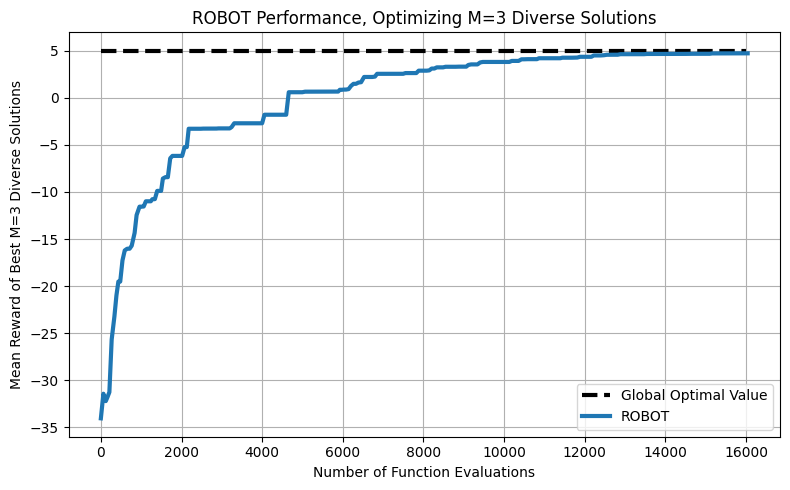

In [12]:
# Plot avg reward vs function evaluations 
# Set figure size
plt.figure(figsize=(8, 5))  
# Plot global optimal value 
plt.plot([0, budget], [5.0, 5.0], "k--", lw=3, label="Global Optimal Value")
# Plot optimization performance 
plt.plot(n_func_evals_per_step, avg_reward_per_step, label="ROBOT", linewidth=3.0)
plt.title(f"ROBOT Performance, Optimizing M={M} Diverse Solutions") 
plt.xlabel("Number of Function Evaluations")
plt.ylabel(f"Mean Reward of Best M={M} Diverse Solutions")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show();

## Visualize ROBOT's optimized solutions
Here, we depict $M=3$ diverse solutions found by ROBOT. Notice that all three solutions successfully naviagate from the start point to the "goal" point while avoiding the obstacles (the dark red rectanges). Also notice that the $M=3$ solutions found by ROBOT are diverse: they take distinctly different paths around the obstacles. 

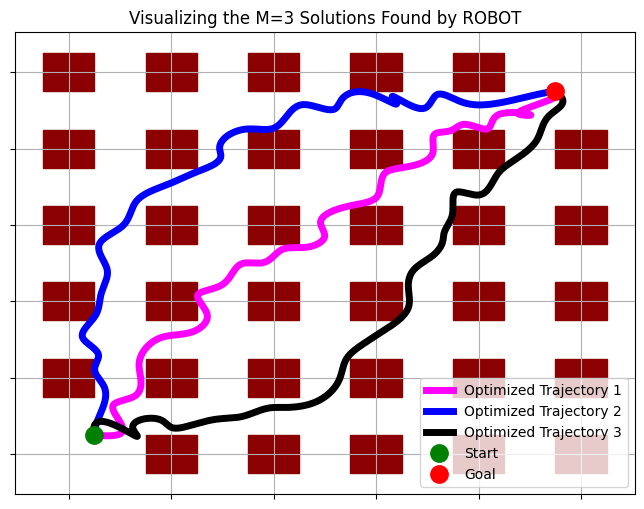

In [16]:
_, ax = plt.subplots(1, 1, figsize=(8, 6))
# Depict obstacles as dark red rectangles 
for i in range(len(rover_objective.obstacle_l)):
    rect = patches.Rectangle(
        (rover_objective.obstacle_l[i, 0], rover_objective.obstacle_l[i, 1]),
        rover_objective.obstacle_delta,
        rover_objective.obstacle_delta,
        linewidth=1,
        edgecolor="darkred",
        facecolor="darkred",
    )
    ax.add_patch(rect) 
traj_colors = ["magenta", "blue", "black"]
for ix, solution_x in enumerate(best_m_xs):
    trajectory = rover_objective.get_trajectory_points(solution_x)
    plt.plot(trajectory[:, 0], trajectory[:, 1], color=traj_colors[ix], linewidth=5.0, label=f"Optimized Trajectory {ix+1}")
plt.plot(0.05, 0.05, ".g", ms=25, label="Start")  # Start
plt.plot(0.95, 0.95, ".r", ms=25, label="Goal") # Goal
plt.legend()
plt.grid(True)
# Add grid lines
ax.grid(True)
# Turn off axis labels (numbers) but keep ticks (and thus the grid lines)
ax.set_xticklabels([])  # Remove x-axis tick labels
ax.set_yticklabels([])  # Remove y-axis tick labels
plt.title(f"Visualizing the M={M} Solutions Found by ROBOT")
plt.show();